## Purpose statement

*Defined problem*: classification<br>
We will attempt to classify the species of an iris flower based on measurments included in the *iris dataset*.

*Success metric*: model prediction accuracy<br>
With our classification goal, we can use model accuracy to determine success of our model.

*Pipeline*: for web<br>
Our data analysis is only one part of a larger pipeline for a public-facing website that will be able to classify species of flower based on uploaded images.

## Import required libraries
The following libraries will be used in this analysis:
<ul>
    <li><b>Numpy</b>: Adds numerical arrays and helper functions.</li>
    <li><b>Pandas</b>: Adds dataframe structure to more easily and efficiently work with data.</li>
    <li><b>scikit-learn</b>: Machine Learning for Python.</li>
    <li><b>matplotlib</b>: Pyplot module for basic plotting of dataframes.</li>
    <li><b>Seaborn</b>: Statistical plotting library.</li>
</ul>

In [1]:
# data libraries
import pandas as pd
import numpy as np

# machine learning libraries
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Tidy Data

<ul>
    <li>What type of data are we dealing with?</li>
    <li>How much cleaning will be necessary to make the data useful?</li>
    <li>Any missing values?</li>
</ul>

In [2]:
iris = pd.read_csv('iris.csv')
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


The data is already in a useable format. The first row contains the headers, which are descriptive and in an easy format to use dot notation.

**We should immediately check for missing values** so that doesn't bite us later. I like to use *.info()* to get the shape of the dataframe, count of nulls, and dtypes simultaneously.

In [3]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


*Nice!* No missing values and data is formatted appropriately.

**Next we should get to know our data.** The best way to get an initial impression of data is to visualize it. I will use seaborn's scatterplot to visualize the distribution of data for each variable. Because our goal is to classify the species, I will set that variable as our *hue*.

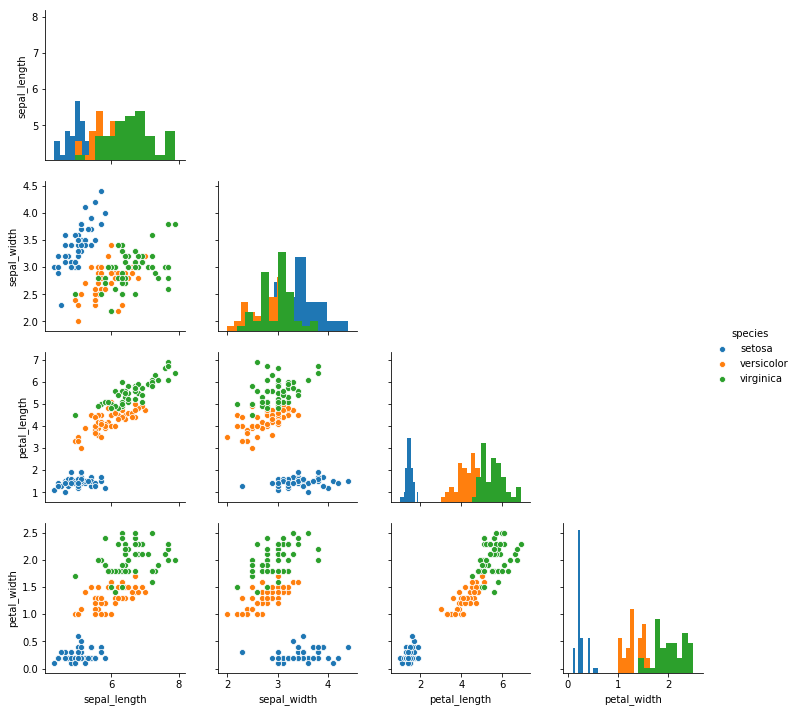

In [4]:
# sns.pairplot(d_iris, hue='species', diag_kind='hist')

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = sns.pairplot(iris, hue='species', diag_kind='hist')
g.map_upper(hide_current_axis)
plt.show()

Overall, this dataset looks really clean already. It also looks like iris-setosa will be easily classified as it is very different from both iris-versicolor and iris-virginica. However, it does seem like there may be an outlier or two within the iris-setosa data. We should dig deeper into each species to check for outliers.

**Dealing with outliers:**
Nearly every data set is going to have outliers, and there are a plethora of reasons they can appear. Knowing this, it will be extremely important to handle them judiciously, and document any changes or exclusions with solid explanations for your decision. 

We can quickly get some high-level statistical data with *.describe()* and then use matplotlib and seaborn to visualize our variable data by species using a boxplot.

In [5]:
desc_setosa = iris[iris.species=='setosa'].describe()
desc_versicolor = iris[iris.species=='versicolor'].describe()
desc_virginica = iris[iris.species=='virginica'].describe()

print(f"""
==Setosa==
{desc_setosa}

==Versicolor==
{desc_versicolor}

==Virginica==
{desc_virginica}
""")


==Setosa==
       sepal_length  sepal_width  petal_length  petal_width
count      50.00000    50.000000     50.000000    50.000000
mean        5.00600     3.428000      1.462000     0.246000
std         0.35249     0.379064      0.173664     0.105386
min         4.30000     2.300000      1.000000     0.100000
25%         4.80000     3.200000      1.400000     0.200000
50%         5.00000     3.400000      1.500000     0.200000
75%         5.20000     3.675000      1.575000     0.300000
max         5.80000     4.400000      1.900000     0.600000

==Versicolor==
       sepal_length  sepal_width  petal_length  petal_width
count     50.000000    50.000000     50.000000    50.000000
mean       5.936000     2.770000      4.260000     1.326000
std        0.516171     0.313798      0.469911     0.197753
min        4.900000     2.000000      3.000000     1.000000
25%        5.600000     2.525000      4.000000     1.200000
50%        5.900000     2.800000      4.350000     1.300000
75%        6

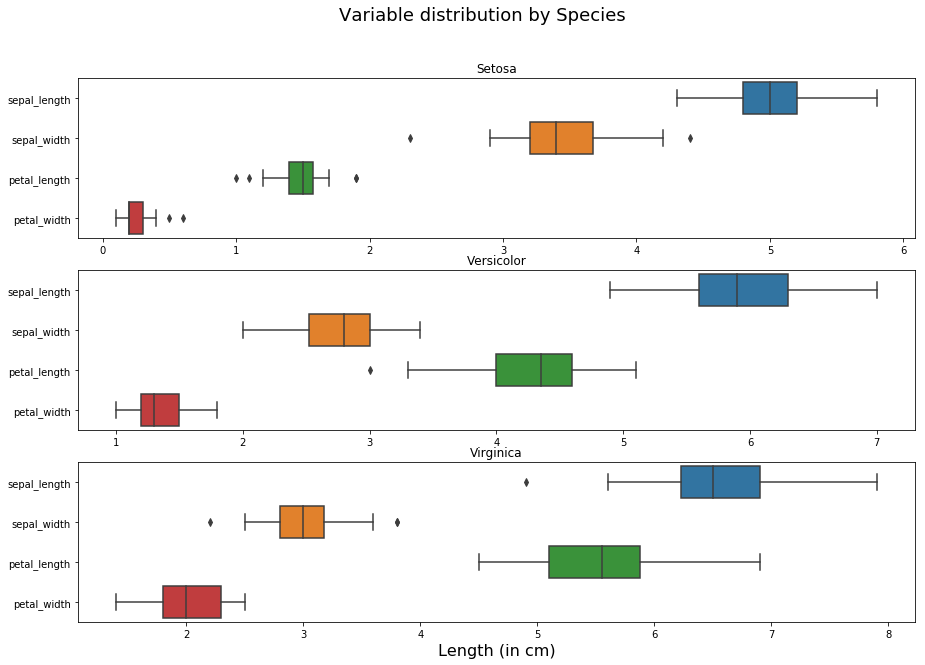

In [6]:
f, axs = plt.subplots(1,3, figsize=(15, 10))
f.suptitle('Variable distribution by Species', fontsize=18)

plt.subplot(3,1,1)
sns.boxplot(data=iris[iris.species=='setosa'], orient='h')
plt.title('Setosa')

plt.subplot(3,1,2)
sns.boxplot(data=iris[iris.species=='versicolor'], orient='h')
plt.title('Versicolor')

plt.subplot(3,1,3)
sns.boxplot(data=iris[iris.species=='virginica'], orient='h')
plt.title('Virginica')

plt.xlabel('Length (in cm)', fontsize=16)
# plt.tight_layout()
plt.show()

**The grouped boxplot** is a perfect way to visualize our data for each variable in each species. Boxplots are a visual representation of the summary statistics from the *.describe()* above. However, they also highlight outliers.

>**Need to know**: Boxplots show "minimum", first quartile, median, third quartile, and "maximum". The *box* in a boxplot is the IQR (inter-quartile range), which is the distance between the 25th-percentile (first quartile) and 75th-percentile (third quartile). The median is represented by a line somewhere inside the colored box. Outliers are represented as dots outside the "minimum" or "maximum" range, which are set equal to the value that is 1.5 times the IQR outside of the IQR.

Our boxplot is telling us that we have outliers; however, an issue with any measure of standard deviation in a dataset this small is that you are likely to assume too many values are outliers. 

Let's look at the observed petal lengths for setosa species, which looks to have 3 outliers based on the boxplot above.

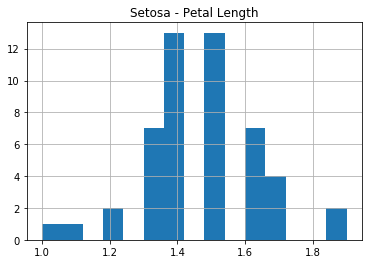

In [7]:
iris[iris.species=='setosa']['petal_length'].hist(bins=15)
plt.title('Setosa - Petal Length')
plt.show()

Based on the above histogram, I wouldn't call any of these values outliers. The distribution is fairly normal, and there are actually two observations just above 1.8cm. In a dataset this small, two observations are too many to be considered an outlier.

Let's compare this histogram to one for setosa sepal length.

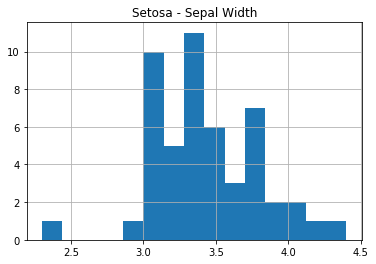

In [8]:
iris[iris.species=='setosa']['sepal_width'].hist(bins=15)
plt.title('Setosa - Sepal Width')
plt.show()

Unlike before, we have an obvious outlier below 2.5cm, we will need to take care of this one. This observation could be an typo in the dataset, an odd actual observation, or any number of other reasons. Because the actual reason for this observation would be nearly impossible to figure out, we should just remove it. Below is the observation we will remove.

>**A note on excluding outliers:** This observation can be safely excluded; however, in datasets where one observation has an affect on other observations (such as time-series data) there may be better processes of dealing with outliers.

In [9]:
print("===Observation to Drop===")
iris[(iris.species == 'setosa')&(iris.sepal_width <= 2.5)]

===Observation to Drop===


,sepal_length,sepal_width,petal_length,petal_width,species
41,4.5,2.3,1.3,0.3,setosa


In [10]:
iris.drop([41], inplace=True)

In [11]:
iris.iloc[40:43,:]

,sepal_length,sepal_width,petal_length,petal_width,species
40,5.0,3.5,1.3,0.3,setosa
42,4.4,3.2,1.3,0.2,setosa
43,5.0,3.5,1.6,0.6,setosa


Drop confirmed. Now let's check the Versicolor petal length.

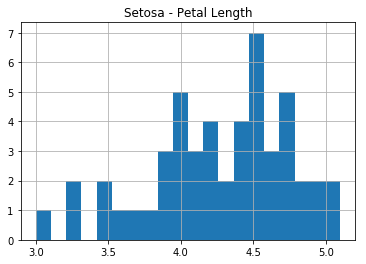

In [30]:
iris[iris.species=='versicolor']['petal_length'].hist(bins=20)
plt.title('Setosa - Petal Length')
plt.show()

In [40]:
print("==Smallest Versicolor Petal Length Observations==")
iris[iris.species=='versicolor']['petal_length'].sort_values()[:4]

==Smallest Versicolor Petal Length Observations==


98    3.0
93    3.3
57    3.3
79    3.5
Name: petal_length, dtype: float64

It doesn't seem to be an outlier. The data suggests that most values are above 4.0cm, and that there's far more variance on the versicolor observations on the smaller end.

For the last species, virginica, we should check the sepal length and width.

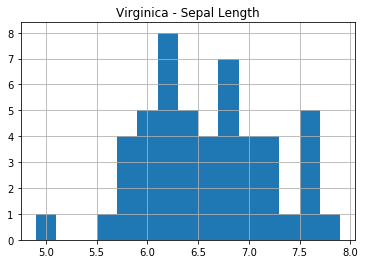

In [33]:
iris[iris.species=='virginica']['sepal_length'].hist(bins=15)
plt.title('Virginica - Sepal Length')
plt.show()

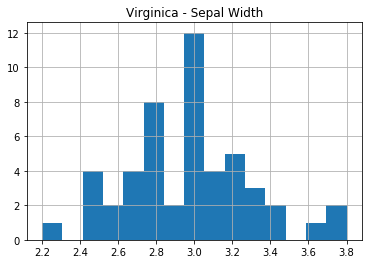

In [31]:
iris[iris.species=='virginica']['sepal_width'].hist(bins=15)
plt.title('Virginica - Sepal Width')
plt.show()

In [38]:
print("==Smallest Virginica Sepal Length Observations==")
iris[iris.species=='virginica']['sepal_length'].sort_values()[:4]

==Smallest Virginica Sepal Length Observations==


106    4.9
121    5.6
113    5.7
101    5.8
Name: sepal_length, dtype: float64

In [39]:
print("==Smallest Virginica Sepal Width Observations==")
iris[iris.species=='virginica']['sepal_width'].sort_values()[:4]

==Smallest Virginica Sepal Width Observations==


119    2.2
108    2.5
113    2.5
106    2.5
Name: sepal_width, dtype: float64

It's never ideal to exclude data, but in this case I believe that observation 106, a Virginica with sepal length of 4.9, is likely an outlier.

In [41]:
print("===Observation to Drop===")
iris[(iris.species == 'virginica')&(iris.sepal_length <= 4.9)]

===Observation to Drop===


,sepal_length,sepal_width,petal_length,petal_width,species
106,4.9,2.5,4.5,1.7,virginica


In [42]:
iris.drop([106], inplace=True)

Now that we have clean data with no missing values or outliers, we can visualize our final data that we will begin Exploratory Data Analysis.

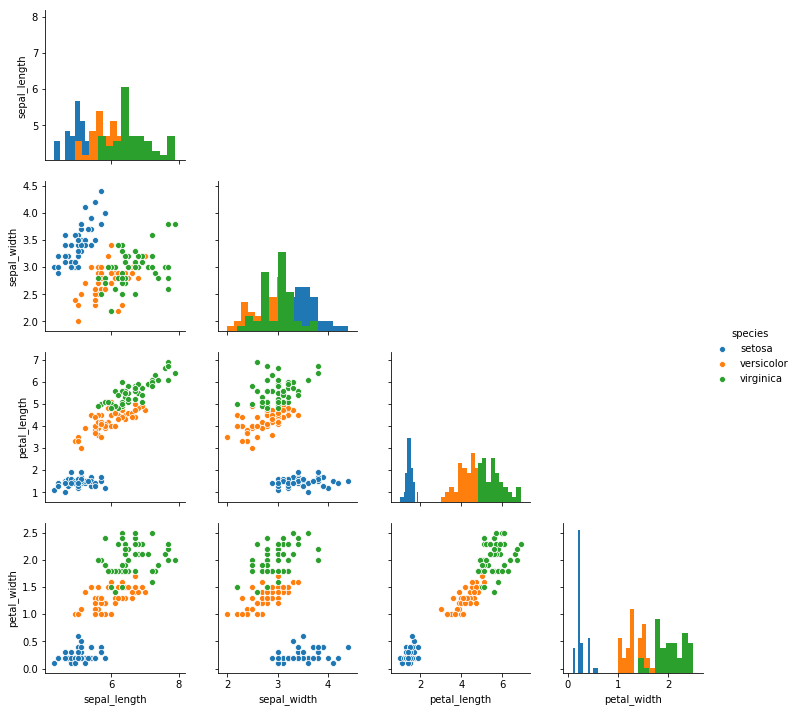

In [43]:
g = sns.pairplot(iris, hue='species', diag_kind='hist')
g.map_upper(hide_current_axis)
plt.show()

## EDA
Now that we have spent far too much time tidying up, we can finally start our analysis.

At this stage, I'm mostly concerned with:
<ul>
    <li>Distribution</li>
    <li>Correlation</li>
    <li>Explanatory factors</li>
</ul>

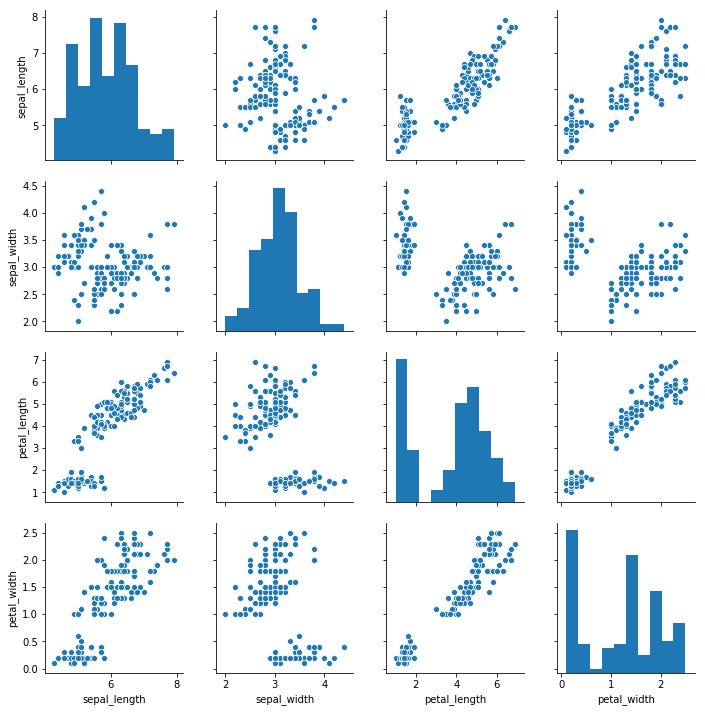

In [46]:
sns.pairplot(iris)
plt.show()

Overall, our data seems to be normally distributed, which gives us more options of models we can run on the data. We do see some variance in the petal lengths and widths so let's visualize by species to check.

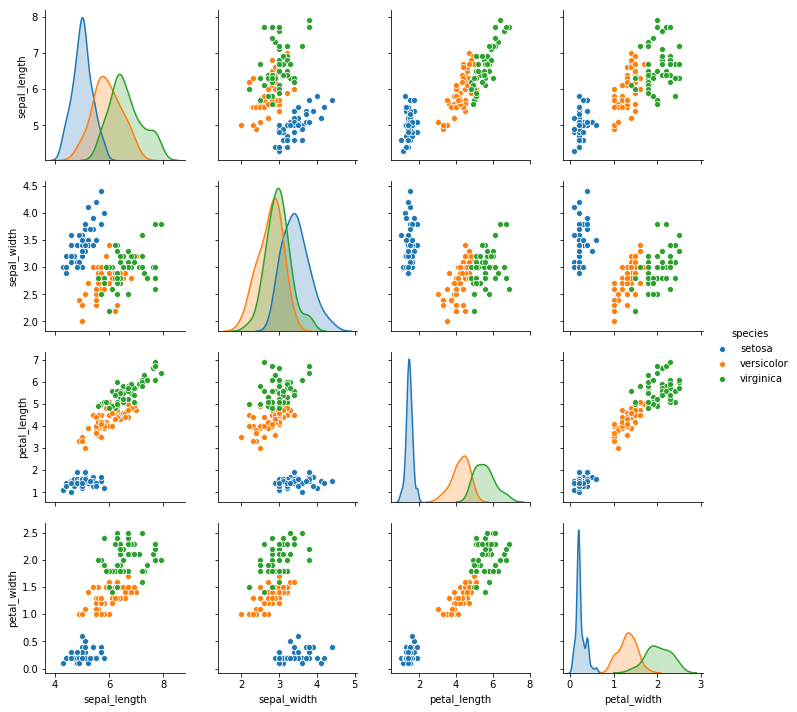

In [47]:
sns.pairplot(iris, hue = 'species')
plt.show()

We can see that the setosa species is easily distinguishable from the versicolor and virginica species. It also seems that there is a correlation between petal length and petal width. The plots seem to suggest that larger petals are also wider.

In [50]:
iris.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.151050,0.877678,0.826171
sepal_width,-0.151050,1.000000,-0.451582,-0.382739
petal_length,0.877678,-0.451582,1.000000,0.962716
petal_width,0.826171,-0.382739,0.962716,1.000000
